# IDS Final Project
SHILOK KUMAR & AMMEN QURESHI

READING DATA

In [76]:
import json
import pandas as pd
import numpy as np

with open('electronics.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

DATA INFORMATION ABOUT THE DATA SET

In [77]:
print("----------------------[DATA INFORMATION]----------------------")
print(f"There are {df.size} cells/values in the provided dataset.")
rows, cols = df.shape
print(f"There are {rows} rows and {cols} columns in the provided Datasets.")
print(f"Dimensions of the Given Data : {df.ndim}")
mvalues = df.apply(lambda x: x=='').sum()
total = mvalues.sum()
print("Total Missing Values Across All Columns:", total)
print("DATA INFO: ")
df.info(verbose = False)

----------------------[DATA INFORMATION]----------------------
There are 19000 cells/values in the provided dataset.
There are 1000 rows and 19 columns in the provided Datasets.
Dimensions of the Given Data : 2
Total Missing Values Across All Columns: 664
DATA INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 19 entries, Customer_ID to Will_Purchase_Next_Month
dtypes: int64(1), object(18)
memory usage: 148.6+ KB


DATA CLEANING

In [78]:
nullValues = df.apply(lambda x: x=='').sum()
print("THESE ARE THE COLUMNS OF THE DATASET WITH THE COUNT OF NULL VALUES")
print(nullValues)
print("Total Missing Values in The Provided DataSet :",nullValues.sum())

#replacing blank spaces with NA values 
df.replace("", pd.NA, inplace=True)

categorical=[
    "Customer_ID", 
    "Gender", 
    "Income_Level", 
    "Address", 
    "Transaction_ID", 
    "Product_ID", 
    "Product_Category", 
    "Brand", 
    "Purchase_Date", 
    "Product_Category_Preferences", 
    "Month", 
    "Season",   
]
numerical=[
    "Age", 
    "Purchase_Amount", 
    "Average_Spending_Per_Purchase", 
    "Purchase_Frequency_Per_Month", 
    "Brand_Affinity_Score", 
    "Year"
]
#Replacing Null values is Categorical Data with Most Frequent Values and Numerical Data With Mean Values
for col in numerical:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df[numerical]=df[numerical].fillna(df[numerical].mean())
df[categorical] = df[categorical].apply(lambda col: col.fillna(col.mode()[0]))
print("Total Missing Values After Data Cleaning:",df.isna().sum().sum())


#Addressing Inconsistencies
df['Season'] = df['Season'].str.title()
seasons=['Fall','Winter','Spring','Summer']
df=df[df['Season'].isin(seasons)]

df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce') 
df['Income_Level']=df['Income_Level'].str.capitalize()




THESE ARE THE COLUMNS OF THE DATASET WITH THE COUNT OF NULL VALUES
Customer_ID                      32
Age                              33
Gender                           33
Income_Level                     41
Address                          32
Transaction_ID                   39
Purchase_Date                    35
Product_ID                       40
Product_Category                 44
Brand                            46
Purchase_Amount                  33
Average_Spending_Per_Purchase    26
Purchase_Frequency_Per_Month     37
Brand_Affinity_Score             47
Product_Category_Preferences     31
Month                            40
Year                             39
Season                           36
Will_Purchase_Next_Month          0
dtype: int64
Total Missing Values in The Provided DataSet : 664
Total Missing Values After Data Cleaning: 0


REMOVING OUTLIERS USING IQR METHOD: 

In [79]:
def removeOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    iqr = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr
    print(f"{column}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")

    outliers=(df[column]<lower_bound)|(df[column]> upper_bound)

    print(f"Outliers:",outliers.value_counts())
    
    mean = df[column].mean()
    print(f"Mean value: {mean}")
    
    # Replacing the outliers with the mean value
    df.loc[outliers, column] = mean
    return df

for column in numerical:
    df=removeOutliers(df,column)
    print('\n')


Age
Lower Bound: -11.5
Upper Bound: 112.5
Outliers: Age
False    988
Name: count, dtype: int64
Mean value: 49.75661057692308


Purchase_Amount
Lower Bound: -211.0
Upper Bound: 717.0
Outliers: Purchase_Amount
False    988
Name: count, dtype: int64
Mean value: 251.1156208891557


Average_Spending_Per_Purchase
Lower Bound: -36.625
Upper Bound: 140.375
Outliers: Average_Spending_Per_Purchase
False    988
Name: count, dtype: int64
Mean value: 51.54000189777329


Purchase_Frequency_Per_Month
Lower Bound: -4.5
Upper Bound: 15.5
Outliers: Purchase_Frequency_Per_Month
False    988
Name: count, dtype: int64
Mean value: 5.442914979757085


Brand_Affinity_Score
Lower Bound: -4.5
Upper Bound: 15.5
Outliers: Brand_Affinity_Score
False    988
Name: count, dtype: int64
Mean value: 5.371258078841734


Year
Lower Bound: 1946.875
Upper Bound: 2047.875
Outliers: Year
False    988
Name: count, dtype: int64
Mean value: 1996.9433198380566




# Data transformation
- Introducing New Features
    - INCOME VALUE : It Calculates Income Value Based On Income Level.
    - SPENDING CAPACITY: It calculates the percentage of a customer's income that they spend on an average purchase.
    - AVERAGE SPENDING : It calculates the average amount of money a customer spends on each purchase.
    - LOYALTY SCORE : It Calculates to estimates a customer's brand loyalty or commitment to purchasing from the brand. 
    - AGE GROUPS : Labeling Customer based on their Age

In [80]:
# INCOME VALUE
income={
    "Low": 2000,     
    "Medium": 5000, 
    "High": 10000    
}
df['Income_Value']=df['Income_Level'].map(income)

# Spending Capacity Percentage = (PURCHASE AMOUNT / INCOME ) * 100
df['Spending_Capacity_Percentage']=(
    (df['Purchase_Amount']/df['Income_Value'])*100
)

#Average Spending Per Purchase = (PURCHASE AMOUNT)/ (PURCHASE FREQUENCY)
df['Average_Spending_Per_Purchase'] = (
    df['Purchase_Amount'].astype(float) / df['Purchase_Frequency_Per_Month'].astype(float)
)

#Loyality Score = (PURCHASE FREQUENCY x BRAND AFFINITY ) + WILL PURCHASE
df['Loyalty_Score']=(
    df['Purchase_Frequency_Per_Month'].astype(float) * df['Brand_Affinity_Score'].astype(float)
) + df['Will_Purchase_Next_Month']


# AGE GROUPS
bins = [0, 25, 35, 55, 100]
labels = ['Young Adult', 'Adult', 'Middle Aged', 'Senior']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

#REMOVING NAN VALUES IF EXIST
newFeatures =[
    'Income_Value','Average_Spending_Per_Purchase','Spending_Capacity_Percentage','Loyalty_Score'
]
for col in newFeatures:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df[newFeatures]=df[newFeatures].fillna(df[newFeatures].mean())



# Normalization 

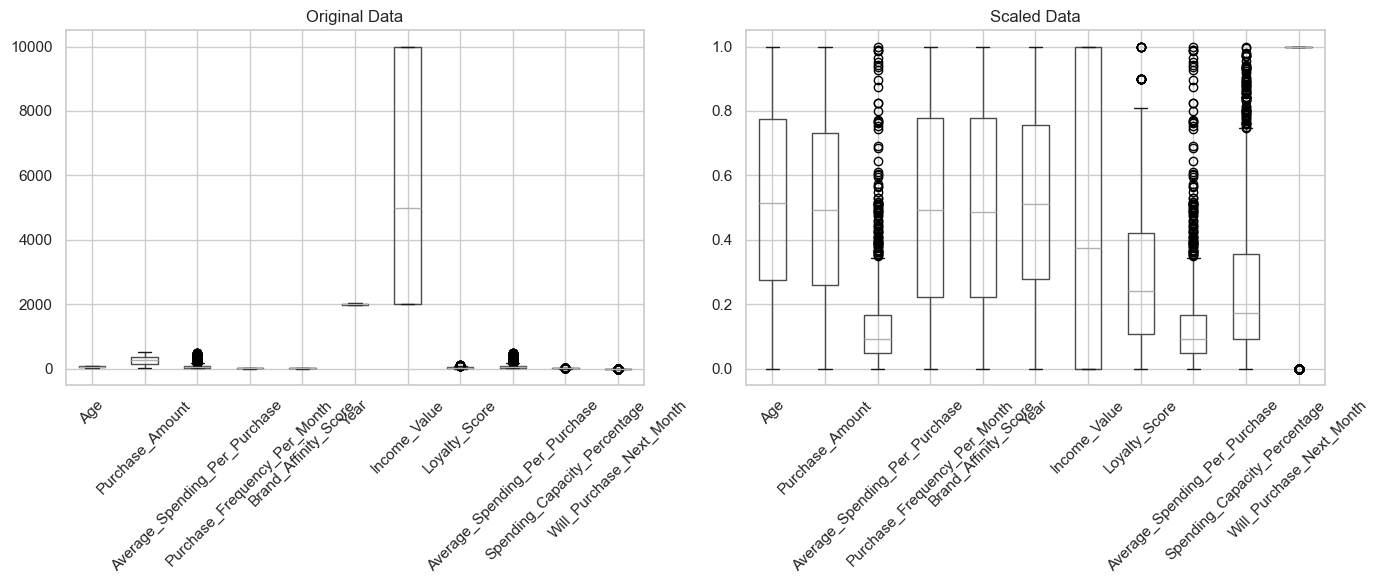

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#numerical columns
numerical_columns = [
    "Age",
    "Purchase_Amount",
    "Average_Spending_Per_Purchase",
    "Purchase_Frequency_Per_Month",
    "Brand_Affinity_Score",
    "Year",
    "Income_Value",
    "Loyalty_Score",
    'Average_Spending_Per_Purchase',
    "Spending_Capacity_Percentage",
    "Will_Purchase_Next_Month"
]

#NORMALIZING
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])

#BOXPLOT
scaledDf = pd.DataFrame(scaled_data, columns=numerical_columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
df[numerical_columns].boxplot(ax=axes[0], rot=45)
axes[0].set_title("Original Data")
scaledDf.boxplot(ax=axes[1], rot=45)
axes[1].set_title("Scaled Data")

plt.tight_layout()
plt.show()


*  Scatter Plot of Two Features Before and After Normalizing

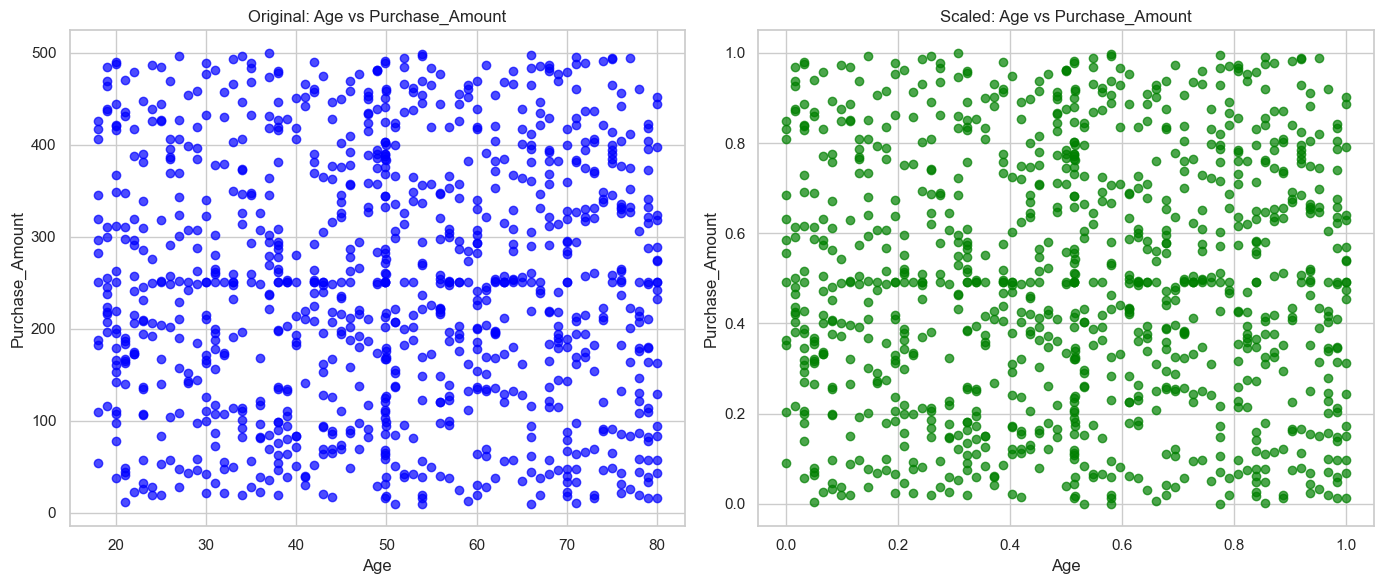

In [82]:
import matplotlib.pyplot as plt

# Scatter plot for two features before and after scaling
feature_x = "Age"  # Replace with feature of your choice
feature_y = "Purchase_Amount"  # Replace with another feature of your choice

plt.figure(figsize=(14, 6))

# Original data scatter plot
plt.subplot(1, 2, 1)
plt.scatter(df[feature_x],df[feature_y], color='blue', alpha=0.7)
plt.title(f"Original: {feature_x} vs {feature_y}")
plt.xlabel(feature_x)
plt.ylabel(feature_y)

# Scaled data scatter plot
plt.subplot(1, 2, 2)
plt.scatter(scaledDf[feature_x],scaledDf[feature_y], color='green', alpha=0.7)
plt.title(f"Scaled: {feature_x} vs {feature_y}")
plt.xlabel(feature_x)
plt.ylabel(feature_y)

plt.tight_layout()
plt.show()


# Module 2: Exploratory Data Analysis (EDA)

UNIVARIATE ANALYSIS:

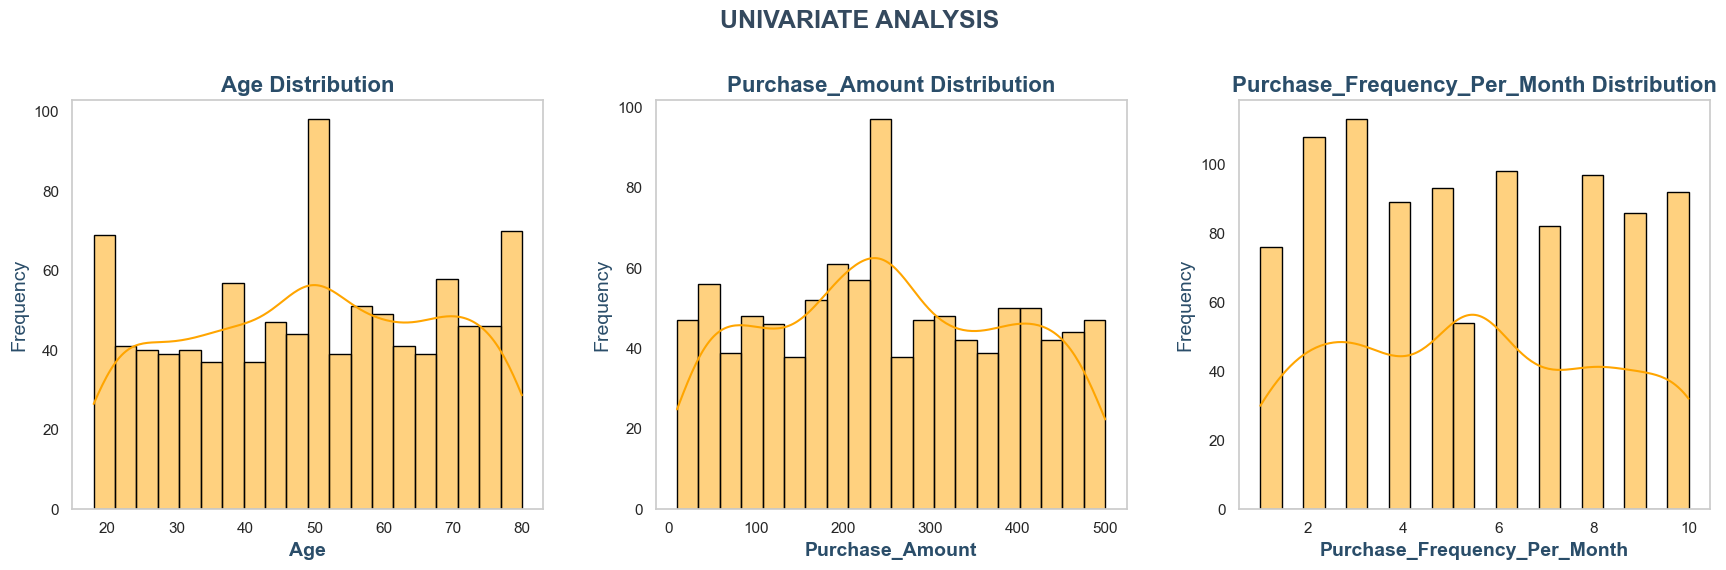

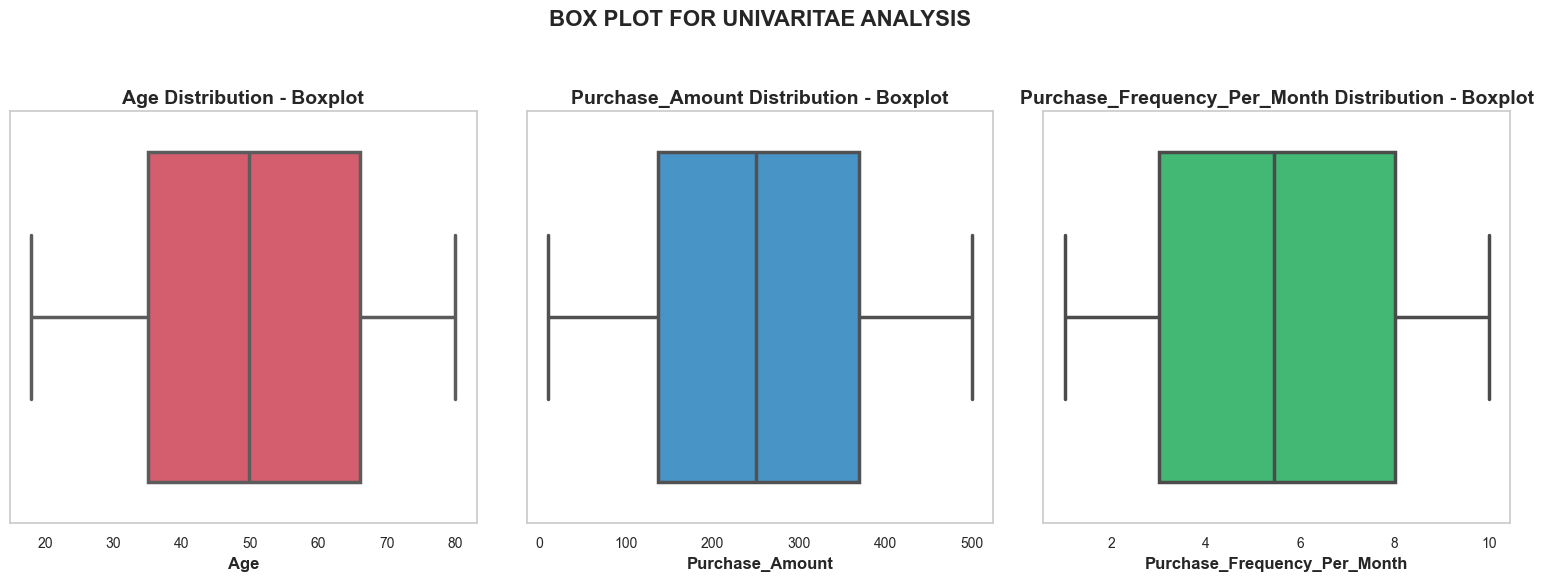

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

features=['Age','Purchase_Amount','Purchase_Frequency_Per_Month']

sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(18, 6))

for i,feature in enumerate(features,1):
    plt.subplot(1, 3, i)  #(row,col,index)
    
    ax = sns.histplot(data=df, x=feature, bins=20, kde=True, color='orange', edgecolor='black')
    ax.set_title(f'{feature} Distribution', fontsize=16, weight='bold',color='#2a4d69')
    ax.set_xlabel(feature, fontsize=14, weight='bold', color='#2a4d69')
    ax.set_ylabel('Frequency', fontsize=14, color='#2a4d69')
    plt.grid(False) 

plt.tight_layout(pad=3.0)
plt.suptitle('UNIVARIATE ANALYSIS',fontsize=18,weight='bold',color='#34495e',y=1.0)

plt.subplots_adjust(top=0.85)
plt.show()

colors=['#e84a5f','#3498db','#2ecc71']
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))

for i, feature in enumerate(features):
    plt.subplot(1,3,i+1)  #(row,column,plot)
    sns.boxplot(x=df[feature],color=colors[i],linewidth=2.5)
    plt.title(f'{feature} Distribution - Boxplot',fontsize=14,weight='bold')
    plt.xlabel(feature,fontsize=12,weight='bold')
    plt.xticks(fontsize=10)
    plt.grid(False)

plt.tight_layout(pad=3.0)
plt.suptitle('BOX PLOT FOR UNIVARITAE ANALYSIS',fontsize=16,weight='bold',y=1.02)

plt.subplots_adjust(top=0.85)
plt.show()

BIVARIATE ANALYSIS:

Text(0.5, 1.02, 'BIVARIATE ANALYSIS')

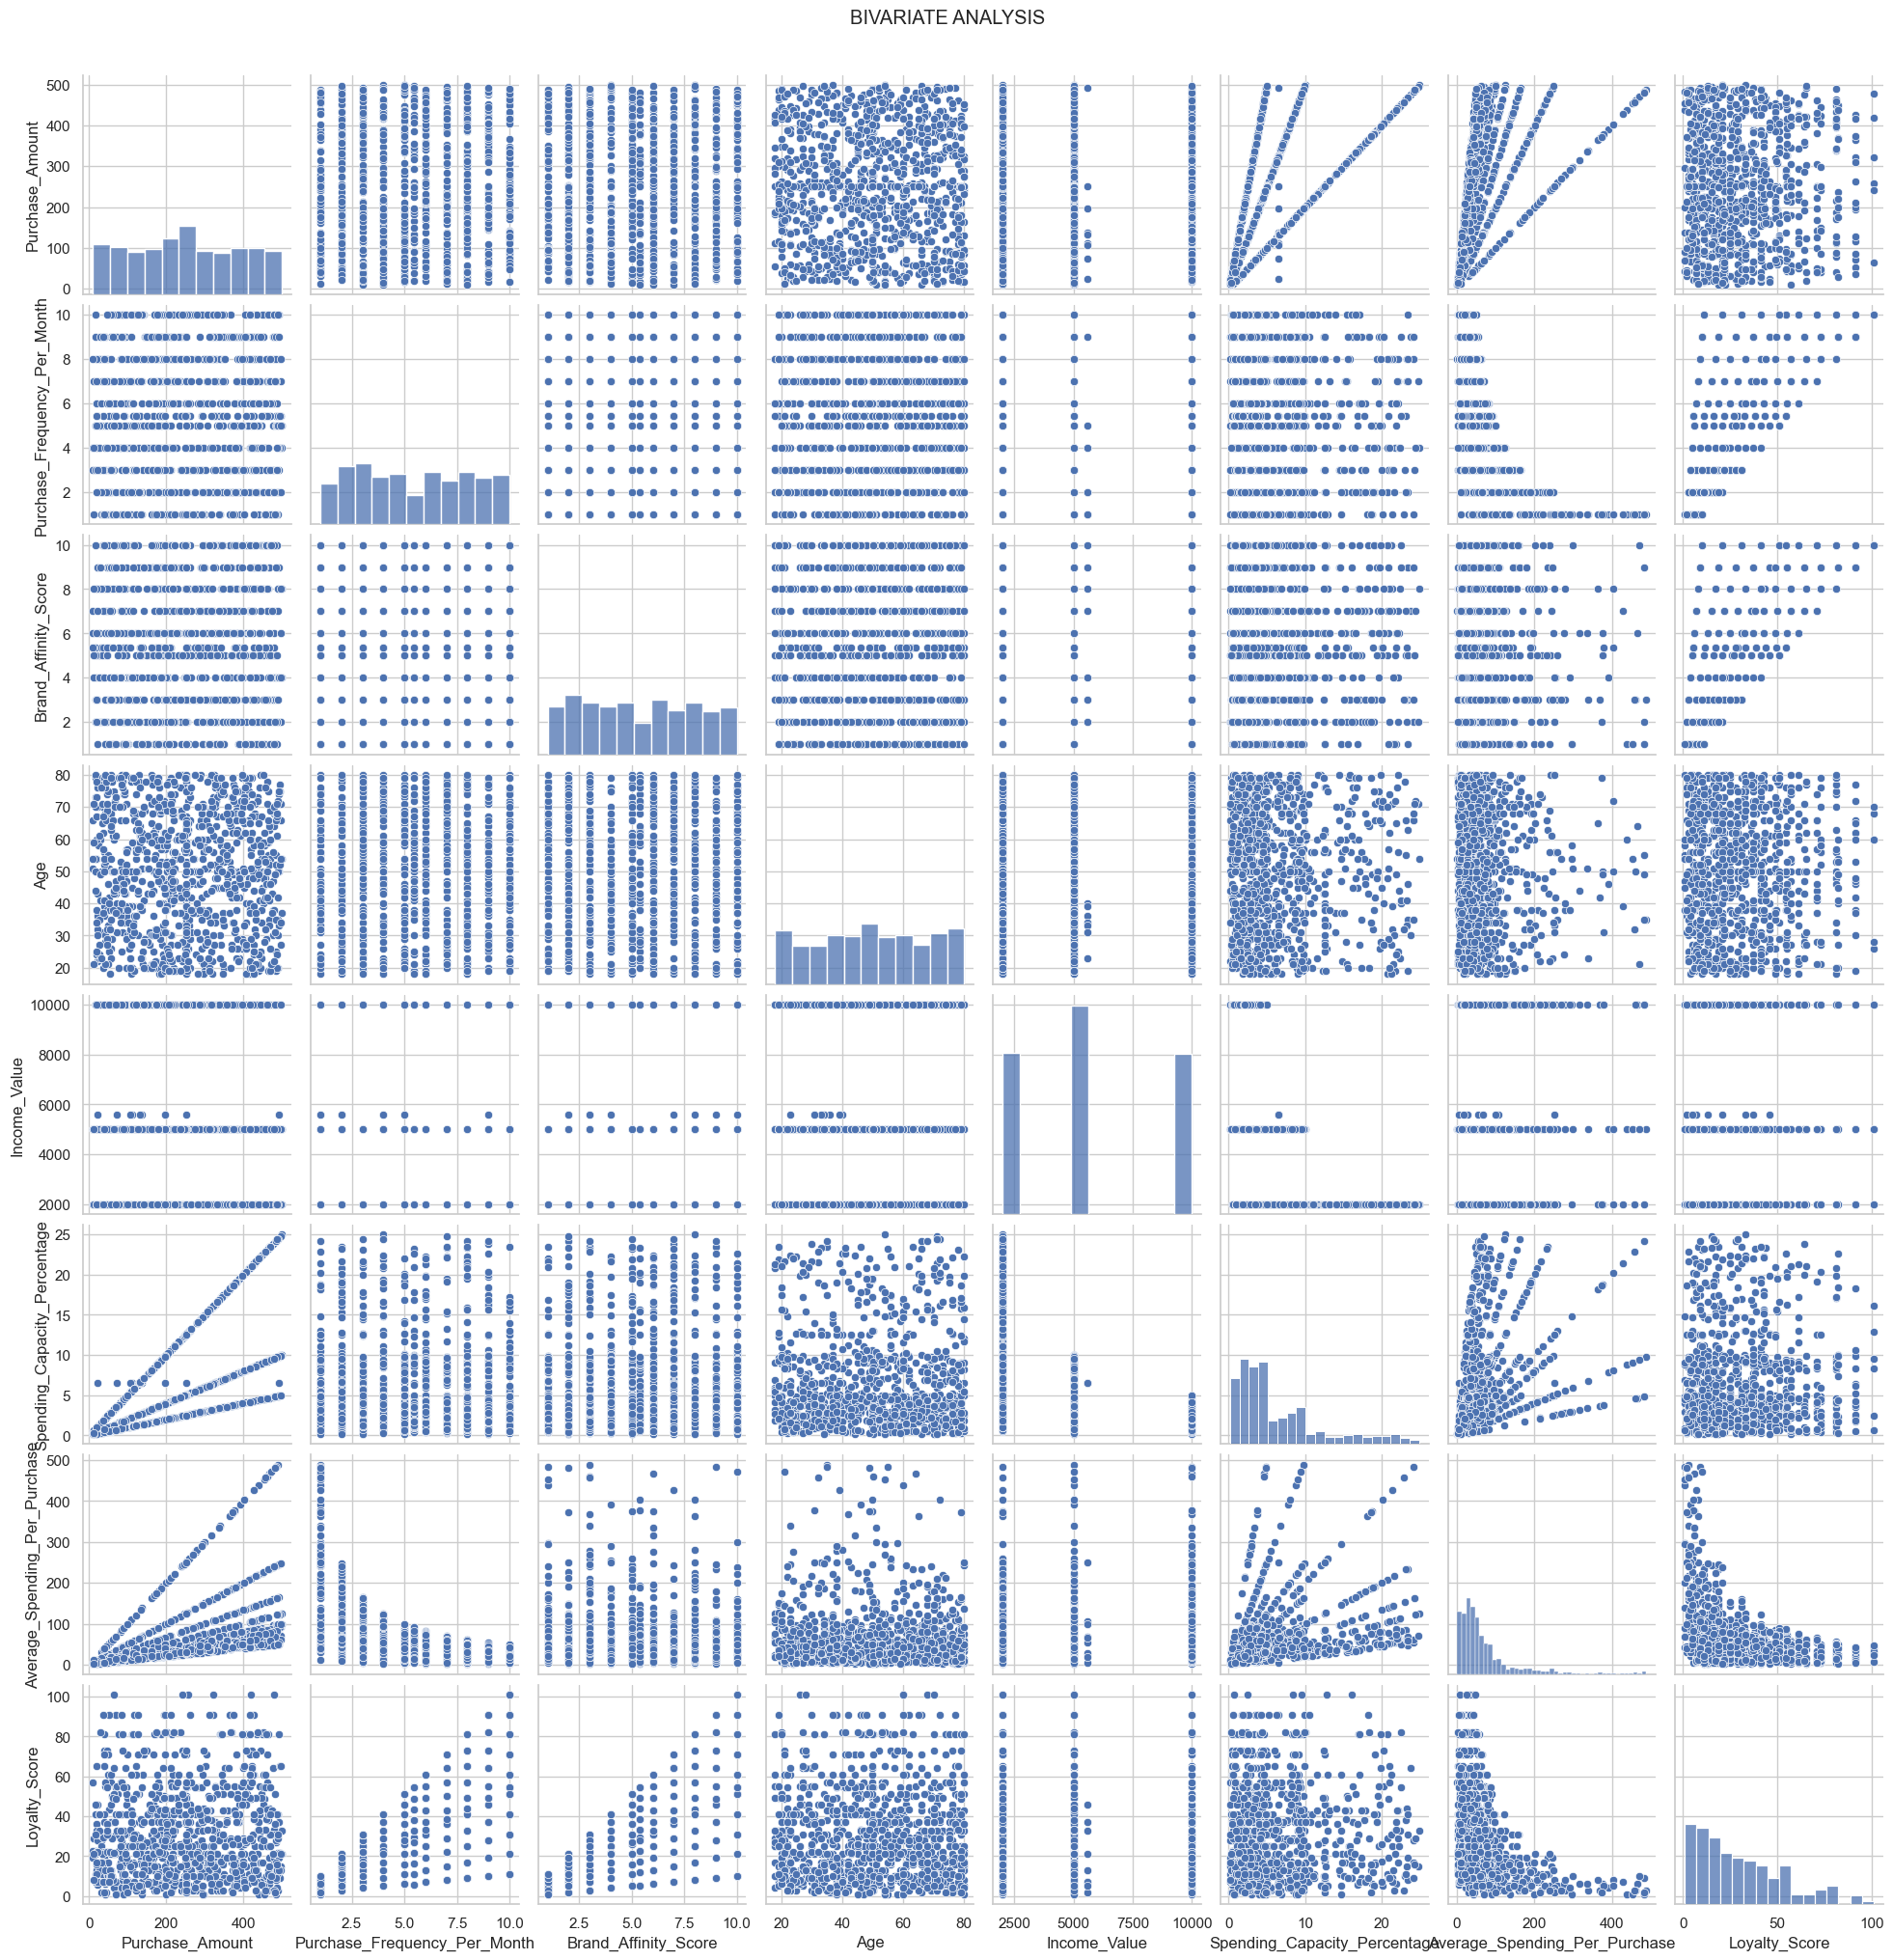

In [84]:
import seaborn as sns
forPlot = ['Purchase_Amount', 'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score', 'Age','Income_Value','Spending_Capacity_Percentage','Average_Spending_Per_Purchase','Loyalty_Score']
plot = sns.pairplot(df,vars=forPlot, hue=None, kind='scatter', diag_kind='auto', palette=None, markers=None)
plot.fig.suptitle("BIVARIATE ANALYSIS", y=1.02) 


* CORRELATION GRAPH

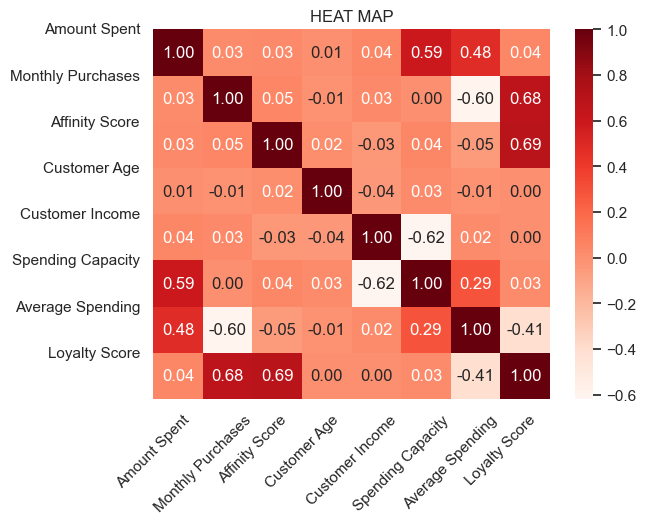

The heatmap shows weak or negligible correlations [all are near to 0] between variables.
No significant relationships are present to investigate further.


In [85]:
forPlot = ['Purchase_Amount', 'Purchase_Frequency_Per_Month', 'Brand_Affinity_Score', 'Age','Income_Value','Spending_Capacity_Percentage','Average_Spending_Per_Purchase','Loyalty_Score']
corr= df[forPlot].corr()
labels = ['Amount Spent', 'Monthly Purchases', 'Affinity Score', 'Customer Age','Customer Income','Spending Capacity','Average Spending','Loyalty Score']
sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.yticks(ticks=range(len(labels)), labels=labels, rotation=0)

plt.title("HEAT MAP")

plt.show()
print("The heatmap shows weak or negligible correlations [all are near to 0] between variables.")
print("No significant relationships are present to investigate further.")

TEMPORAL ANALYSIS:

Purchase Frequency Over Year

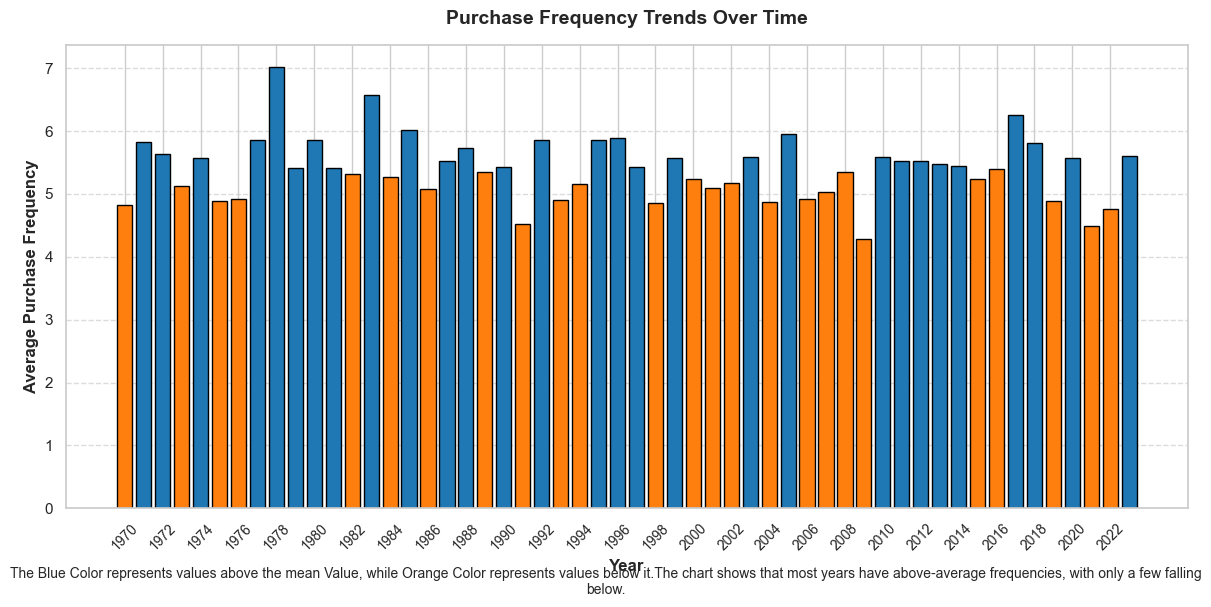

In [86]:
trend = df.groupby('Year')['Purchase_Frequency_Per_Month'].mean().reset_index()

plt.figure(figsize=(12, 6))

bars = plt.bar(
    trend['Year'], 
    trend['Purchase_Frequency_Per_Month'], 
    color=['#1f77b4' if val>trend['Purchase_Frequency_Per_Month'].mean() else '#ff7f0e' for val in trend['Purchase_Frequency_Per_Month']], 
    edgecolor='black'
)

yrs = trend['Year'].astype(int).unique()
ticks = [year for year in yrs if year%2==0]
plt.xticks(ticks, rotation=45, fontsize=10)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Average Purchase Frequency', fontsize=12, fontweight='bold')
plt.title('Purchase Frequency Trends Over Time', fontsize=14, fontweight='bold', pad=15)
plt.figtext(
    0.5, 0.00025,
    "The Blue Color represents values above the mean Value, while Orange Color represents values below it."
    "The chart shows that most years have above-average frequencies, with only a few falling below.",
    ha='center', 
    fontsize=10,
    wrap=True
)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


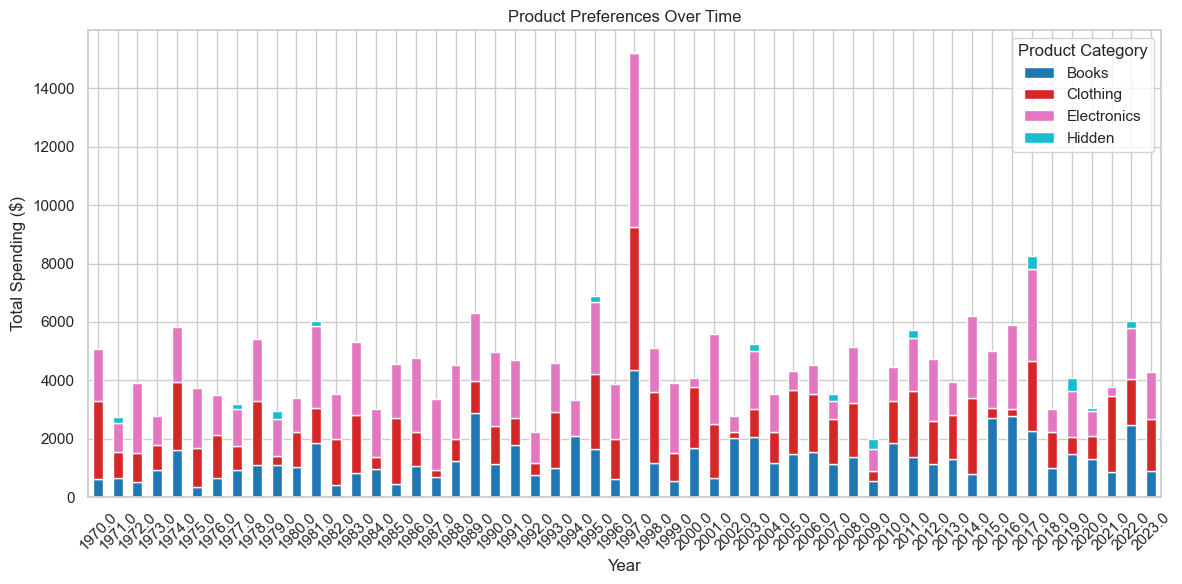

ANALYSIS:
Electronics dominate spending, with major spikes in 1997 and 2018.
Clothing and books contribute steadily,while hidden items have minimal impact. Total spending fluctuates over time.


In [87]:
trend = df.groupby(['Year', 'Product_Category'])['Purchase_Amount'].sum().reset_index()
productPlot = trend.pivot(index='Year', columns='Product_Category', values='Purchase_Amount')

# Stacked bar chart
productPlot.plot(kind='bar',stacked=True,figsize=(12, 6),colormap='tab10')
plt.xlabel('Year')
plt.ylabel('Total Spending ($)')
plt.title('Product Preferences Over Time')
plt.legend(title='Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("ANALYSIS:")
print("Electronics dominate spending, with major spikes in 1997 and 2018." )
print("Clothing and books contribute steadily,while hidden items have minimal impact. Total spending fluctuates over time.")


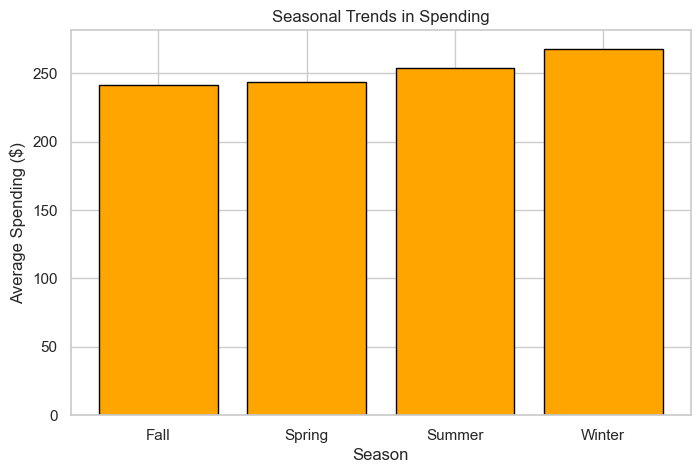

In [88]:
trends = df.groupby('Season')['Purchase_Amount'].mean().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(trends['Season'], trends['Purchase_Amount'], color='orange',edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Average Spending ($)')
plt.title('Seasonal Trends in Spending')
plt.show()


# MODULE 3
- LINEAR REGRESSION ANALYSIS :
    * According to the Problem Statment:
    * Target Value : [averageSpendingPerPurchase]
    - Independent Feature Variables: 
        * Gender (categorical)
        * Income_Level (categorical)
        * Product_Category (categorical)
        * Season (categorical)
        * Age (numerical)
        * Brand_Affinity_Score (numeric)
        * Purchase_Frequency_Per_Month (numeric)
        

    

- PREPROCESSING

In [89]:

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Indepfeatures=["Gender","Income_Level","Product_Category","Season","Age","Brand_Affinity_Score","Purchase_Frequency_Per_Month",'Income_Value','Spending_Capacity_Percentage','Average_Spending_Per_Purchase','Loyalty_Score']
modelData=df[Indepfeatures].copy() 


encode=LabelEncoder()
categorical = ["Gender","Income_Level","Product_Category","Season"]
for col in categorical:
    modelData.loc[:,col]=encode.fit_transform(modelData[col])

scale=MinMaxScaler() #Normalizing the independent Features
numeric_features=["Age", "Brand_Affinity_Score", "Purchase_Frequency_Per_Month"]
modelData.loc[:,numeric_features]=scale.fit_transform(modelData[numeric_features])


- SPLITTING

In [90]:
from sklearn.model_selection import train_test_split

x=modelData 
y=df["Average_Spending_Per_Purchase"]  
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}  --- 80%")
print(f"Testing set size: {X_test.shape} --- 20% ") 


Training set size: (790, 11)  --- 80%
Testing set size: (198, 11) --- 20% 


- TRAINING

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regression=LinearRegression()

regression.fit(X_train,Y_train)

print("Model Coefficients:",regression.coef_)
print("Intercept:",regression.intercept_)

predict=regression.predict(X_test)  # predict = Y 
mse=mean_squared_error(Y_test,predict) 
r2=r2_score(Y_test,predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
# have to add TRANSFORMED FEATURES FOR THE ANALYSIS !!! for best fit 


Model Coefficients: [-4.03484649e-15  6.06181771e-14 -2.92301500e-14 -1.15841751e-15
  4.49913408e-16  8.05869518e-15 -1.90145327e-14 -5.19029264e-15
  5.36587918e-15  1.00000000e+00 -1.19533290e-16]
Intercept: 2.901856532844249e-11
Mean Squared Error (MSE): 2.780128594906946e-22
R-squared (R²): 1.0


* VISUALZING

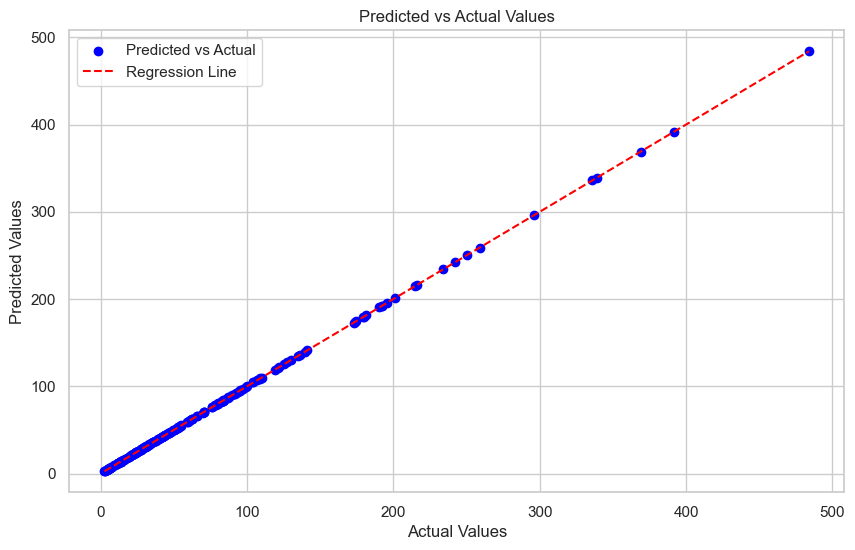

In [ ]:
# Plotting the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, predict, color='blue', label='Predicted vs Actual')

# Plot the regression line (y = mx + c)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Regression Line')

# Adding labels and title
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

# Display the plot
plt.show()


# Decision Tree Analysis
- Independent Features: 
- Profile Data:
    - Age
    - Gender
    - Income_Level
    - Behavioral Features:
- Behavioral Data 
    - Purchase_Frequency_Per_Month: 
    - Average_Spending_Per_Purchase 
    - Brand_Affinity_Score
    - Product Preferences
- Product Preferences
    - Product_Category
    - Product_Category_Preferences

- Target Feature
  - Will Purchase Next Month
    

In [150]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

inputFeatures = ['Age', 'Gender','Income_Level',  
                 'Average_Spending_Per_Purchase', 'Brand_Affinity_Score', 
                 'Month', "Product_Category", "Product_Category_Preferences",'Income_Value','Spending_Capacity_Percentage','Average_Spending_Per_Purchase','Loyalty_Score',
                 'Season',]
inputFeatures = df[inputFeatures]
target = df['Will_Purchase_Next_Month']

encode = LabelEncoder()
columns = ["Gender", "Income_Level", "Product_Category",'Month', 
           "Product_Category_Preferences",'Purchase_Frequency_Per_Month', "Season"]

# ENCODING CATEGORICAL ----> NUMERICAL
for col in columns:
    if col in inputFeatures.columns:
        inputFeatures.loc[:, col]=encode.fit_transform(inputFeatures[col].astype(str))

X_train, X_test, Y_train, Y_test = train_test_split(inputFeatures, target, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=9)
clf.fit(X_train, Y_train)

# EVALUTAIONS
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))


Accuracy: 0.98989898989899
Precision: 0.988950276243094
Recall: 1.0
F1 Score: 0.9944444444444445


* Decision Tree Visualization

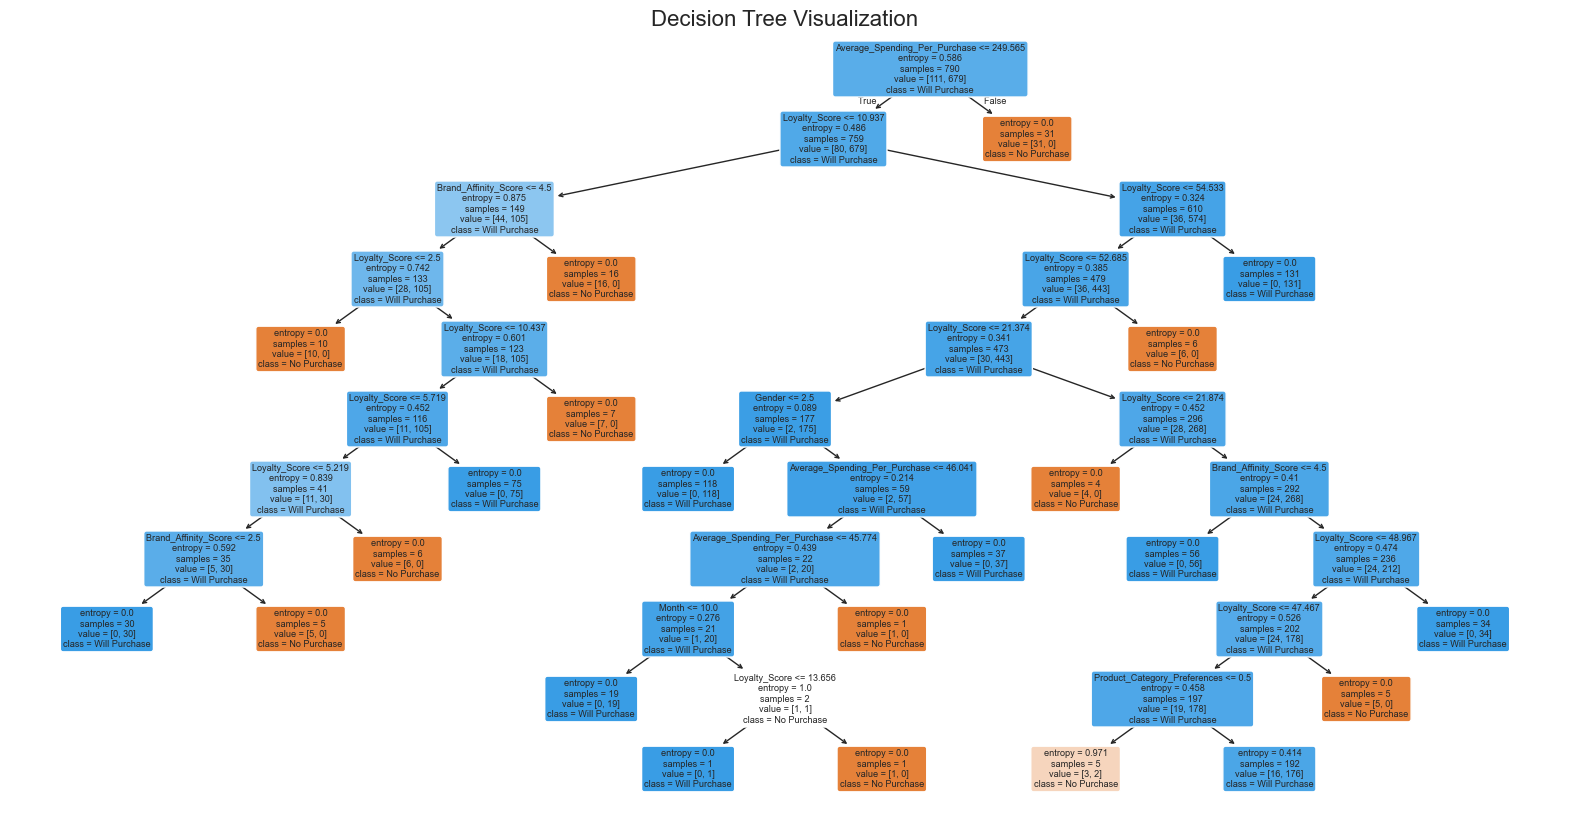

In [151]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, 
          feature_names=inputFeatures.columns, 
          class_names=["No Purchase", "Will Purchase"], 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


* Feature Importances 

Feature Importances:
                          Feature  Importance
11                  Loyalty_Score    0.541115
10  Average_Spending_Per_Purchase    0.258201
4            Brand_Affinity_Score    0.158967
7    Product_Category_Preferences    0.015452
5                           Month    0.010046
1                          Gender    0.008467
3   Average_Spending_Per_Purchase    0.007751
2                    Income_Level    0.000000
0                             Age    0.000000
8                    Income_Value    0.000000
6                Product_Category    0.000000
9    Spending_Capacity_Percentage    0.000000
12                         Season    0.000000


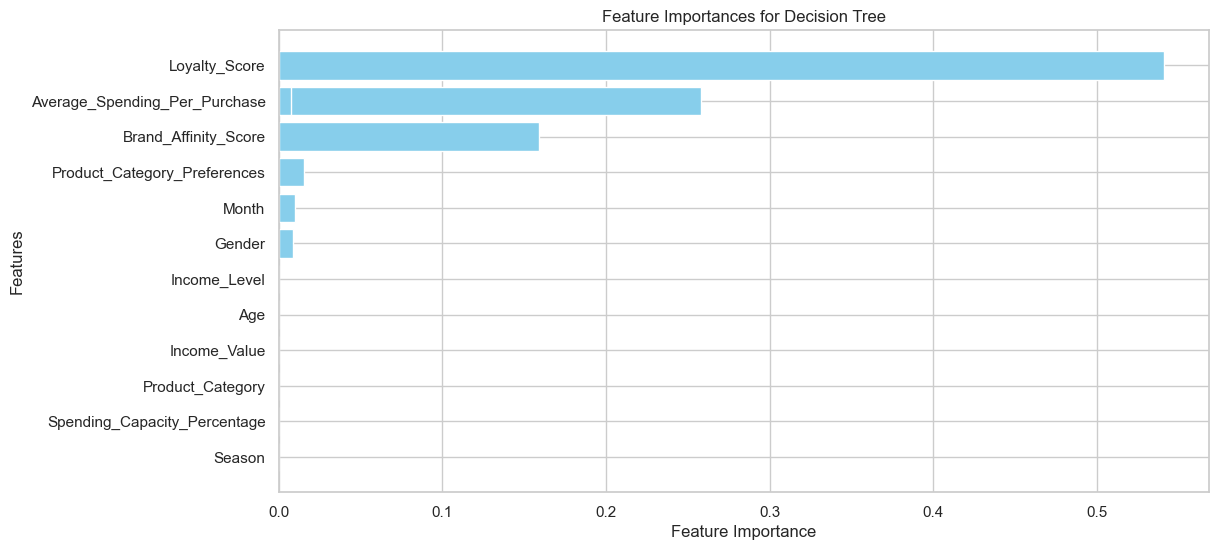

In [153]:
import pandas as pd

# Get feature importances from the trained model
importances = clf.feature_importances_

# Create a DataFrame to display them in descending order
importance_df = pd.DataFrame({
    "Feature": inputFeatures.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print the important features
print("Feature Importances:")
print(importance_df)

# Bar Plot of Feature Importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances for Decision Tree")
plt.gca().invert_yaxis()  
plt.show()


# Module 4: Clusterring Analysis

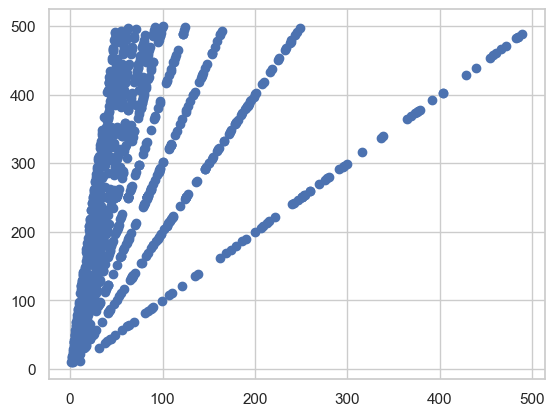

In [ ]:
plt.scatter(df['Average_Spending_Per_Purchase'], df['Purchase_Amount'])

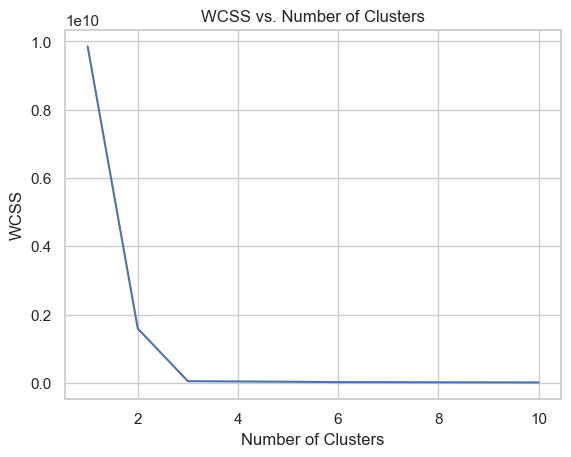

In [155]:
from sklearn.cluster import KMeans

# Ensure you're using only numeric columns from the dataframe
numeric_df = df.select_dtypes(include=[float, int])

# WCSS for different values of k (1 to 10)
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42)  
    km.fit(numeric_df)  
    wcss.append(km.inertia_)

#PLOTTING WCC
plt.plot(range(1, 11), wcss)
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


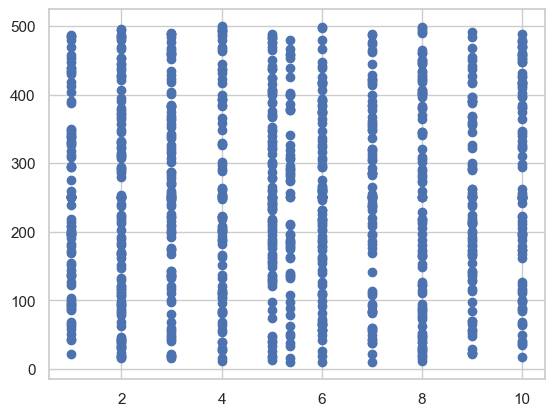

In [157]:
import matplotlib.pyplot as plt
plt.scatter( df['Brand_Affinity_Score'], df['Purchase_Amount'])
